# evaluate_llms.ipynb
# Copyright (c) 2025, Joshua J Hamilton

In this notebook, we will evaluate the ability of different LLMs to tag classical music audio files.

I will evaluate some of the following LLMs:
* Claude 3.5 Sonnet
* DeepSeek R1
* Gemini 2.0 Flash
* GPT o1
* Llama 3.3-70B

To evaluate the LLMs, I will
* Perform prompt engineering to generate prompts for each LLM. Validate prompts based on works I have tagged thus far.
* Evaluate prompts and LLMs and select one for testing.
* Test the optimized prompt on a test set containing the complete works of Beethoven, who was not in the validation set

Validation set:
|updated_composer        |updated_album                                            |updated_orchestra                 |updated_conductor|updated_soloists |
|------------------------|---------------------------------------------------------|----------------------------------|-----------------|-----------------|
|Bach, Johann Sebastian  |Brandenburg Concertos · Orchestral Suites · Chamber Music|Musica Antiqua Köln               |Goebel, Reinhard |                 |
|Bach, Johann Sebastian  |Harpsichord Concertos                                    |Leonhardt-Consort                 |Leonhardt, Gustav|Leonhardt, Gustav|
|Bach, Johann Sebastian  |Harpsichord Concertos                                    |Leonhardt-Consort                 |Leonhardt, Gustav|Curtis, Alan     |
|Bach, Johann Sebastian  |Organ Works                                              |                                  |                 |Walcha, Helmut   |
|Bach, Johann Sebastian  |Complete Bach Collection                                 |                                  |                 |Gould, Glenn     |
|Handel, George Frideric |Concerti Grossi Op 3 & Op 6                              |Münchener Bach-Orchester          |Richter, Karl    |                 |
|Handel, George Frideric |Organ & Harpsichord Music                                |Amsterdam Baroque Orchestra       |                 |Koopman, Ton     |
|Handel, George Frideric |Organ & Harpsichord Music                                |                                  |                 |Ross, Scott      |
|Handel, George Frideric |Organ & Harpsichord Music                                |                                  |                 |Baumont, Olivier |
|Handel, George Frideric |Music for the Royal Fireworks · Water Music              |Academy of St Martin in the Fields|Marriner, Neville|                 |
|Haydn, Joseph           |The Six Organ Concertos                                  |Amsterdam Baroque Orchestra       |Koopman, Ton     |Koopman, Ton     |
|Haydn, Joseph           |Complete Harpsichord Concertos                           |Musica Antiqua Amsterdam          |Koopman, Ton     |Koopman, Ton     |
|Haydn, Joseph           |Complete Music for Solo Keyboard                         |                                  |                 |Brautigam, Ronald|
|Haydn, Joseph           |Complete String Quartets                                 |Angeles String Quartet            |                 |                 |
|Haydn, Joseph           |Complete Symphonies                                      |Austro-Hungarian Haydn Orchestra  |Fischer, Adam    |                 |
|Mozart, Wolfgang Amadeus|Overtures                                                |Staatskapelle Dresden             |Davis, Colin     |                 |
|Mozart, Wolfgang Amadeus|Complete Piano Sonatas                                   |                                  |                 |Brautigam, Ronald|
|Mozart, Wolfgang Amadeus|Serenaden & Divertimenti                                 |Camerata Salzburg                 |Vegh, Sandor     |                 |
|Mozart, Wolfgang Amadeus|The String Quartets                                      |Amadeus Quartet                   |                 |                 |
|Mozart, Wolfgang Amadeus|The String Quintets                                      |Amadeus Quartet                   |                 |Aronowitz, Cecil |
|Mozart, Wolfgang Amadeus|46 Symphonies                                            |Berlin Philharmonic               |Böhm, Karl       |                 |
|Mozart, Wolfgang Amadeus|Piano Concertos                                          |Camerata Salzburg                 |Vegh, Sandor     |Schiff, András   |
|Vivaldi, Antonio        |Vivaldi Edition, Volume 1                                |I Musici                          |                 |                 |
|Vivaldi, Antonio        |Vivaldi Edition, Volume 2                                |I Musici                          |                 |                 |

Test set:
| Genre    | Composer  | Type of Work    | Recording                                    |
| -------- | --------- | --------------- | -------------------------------------------- |
| Romantic | Beethoven | Overtures       | Leipzig Gewandhaus Orchestra with Kart Masur |
| Romantic | Beethoven | Piano Concertos | Wilhelm Kempff                               |
| Romantic | Beethoven | Piano Sonatas   | Alfred Brendel                               |
| Romantic | Beethoven | String Quartets | Emerson String Quartet                       |
| Romantic | Beethoven | Symphonies      | Berlin Philharmonic with Herbert von Karajan |

I will evaluate the LLMs based on the following tags:
* Composer - Composer name, of the form LastName, FirstName (e.g., Beethoven, Ludwig van)
* Album - Full album title on which the track appears
* Year Recorded - Year the track was recorded. Not the year it was released. A four-digit number
* Orchestra - Performing ensemble. May be an orchestra, quartet, etc. Translate the name of the ensemble into English. (e.g., "Wiener Philharmoniker" should be "Vienna Philharmonic")
* Conductor - Conductor name, of the form LastName, FirstName (e.g. "Karajan, Herbert von")
* Soloists - Soloist name, of the form LastName, FirstName. Separate multiple soloists with semi-colons and without a space (e.g., Gould, Glenn;Menuhin, Yehudi)
* Genre - Musical period/style. Allowed values are: Renaissance, Baroque, Classical, Romantic, 20th Century, 21st Century
* Work - The main musical work (e.g. "Symphony", "String Quartet")
* Work Number - Numerical designation (e.g. "No 41"). Should be padded to the length of the largest work number within the specified work (e.g., Haydn's Symphony No 1 should be No 001 because Haydn write 104 symphonies)
* InitialKey - Key signature. Single upper-case letter for major keys, upper-case letter plus minor for minor keys (e.g. "C, "E-flat minor")
* Catalog # - Standard catalog reference. Should be padded to the length of the largest number in the composer's catalog (e.g., Bach's BWV 1 should be BWV 0001 because Bach wrote over 1000 works)
* Opus - Opus designation. Should be padded to the length of the largest opus number in the composer's oeuvre. (e.g., Beethoven's Op 1 should be Op 001 because Beethoven wrote 138 opuses)
* Opus Number - Sub-designation within opus. Should be padded to the length of the highest piece number within the specific opus (e.g., Vivaldi's Op 3 No 1 should be No 01 because Vivaldi wrote 12 concertos in Op 3)
* Epithet - common name (e.g. "Jupiter", "Eroica")
* Movement - movement number and tempo. Use Roman numerals for movements. Separate the movement number and tempo with a period and a space (e.g. "I. Allegro con brio"). If the movement is a dance movement, separate the dance name from the tempo with a colon (e.g. "III. Menuet: Allegro"). If the movement is a multi-part movement, separate the parts with a dash (e.g. "IV. Finale: Allegro - Presto"). If the movement is a multi-part movement with a dance movement, separate the parts with a dash and the dance name from the tempo with a colon (e.g. "III. Menuet: Allegro - Trio: Andante").


Evaluation will be performed by plotting fraction of true positives for each parameter on a spider plot



# Validation

## Import Packages

In [7]:
from pydantic import BaseModel, Field
from openai import OpenAI
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

## Create validation dataset: 1st Attempt

In [2]:
# List of albums to be used in the validation set
# Each album is specified as a list of five tags:
# updated_composer	updated_album	updated_orchestra	updated_conductor	updated_soloists
validation_albums = [
    ['Bach, Johann Sebastian', 'Brandenburg Concertos · Orchestral Suites · Chamber Music', 'Musica Antiqua Köln', 'Goebel, Reinhard', ''],
    ['Bach, Johann Sebastian', 'Harpsichord Concertos', 'Leonhardt-Consort', 'Leonhardt, Gustav', 'Leonhardt, Gustav'],
    ['Bach, Johann Sebastian', 'Harpsichord Concertos', 'Leonhardt-Consort', 'Leonhardt, Gustav', 'Curtis, Alan'],
    ['Bach, Johann Sebastian', 'Organ Works', '', '', 'Walcha, Helmut'],
    ['Bach, Johann Sebastian', 'Complete Bach Collection', '', '', 'Gould, Glenn'],
    ['Handel, George Frideric', 'Concerti Grossi Op 3 & Op 6', 'Münchener Bach-Orchester', 'Richter, Karl', ''],
    ['Handel, George Frideric', 'Organ & Harpsichord Music', 'Amsterdam Baroque Orchestra', '', 'Koopman, Ton'],
    ['Handel, George Frideric', 'Organ & Harpsichord Music', '', '', 'Ross, Scott'],
    ['Handel, George Frideric', 'Organ & Harpsichord Music', '', '', 'Baumont, Olivier'],
    ['Handel, George Frideric', 'Music for the Royal Fireworks · Water Music', 'Academy of St Martin in the Fields', 'Marriner, Neville', ''],
    ['Haydn, Joseph', 'The Six Organ Concertos', 'Amsterdam Baroque Orchestra', 'Koopman, Ton', 'Koopman, Ton'],
    ['Haydn, Joseph', 'Complete Harpsichord Concertos', 'Musica Antiqua Amsterdam', 'Koopman, Ton', 'Koopman, Ton'],
    ['Haydn, Joseph', 'Complete Music for Solo Keyboard', '', '', 'Brautigam, Ronald'],
    ['Haydn, Joseph', 'Complete String Quartets', 'Angeles String Quartet', '', ''],
    ['Haydn, Joseph', 'Complete Symphonies', 'Austro-Hungarian Haydn Orchestra', 'Fischer, Adam', ''],
    ['Mozart, Wolfgang Amadeus', 'Overtures', 'Staatskapelle Dresden', 'Davis, Colin', ''],
    ['Mozart, Wolfgang Amadeus', 'Complete Piano Sonatas', '', '', 'Brautigam, Ronald'],
    ['Mozart, Wolfgang Amadeus', 'Serenaden & Divertimenti', 'Camerata Salzburg', 'Vegh, Sandor', ''],
    ['Mozart, Wolfgang Amadeus', 'The String Quartets', 'Amadeus Quartet', '', ''],
    ['Mozart, Wolfgang Amadeus', 'The String Quintets', 'Amadeus Quartet', '', 'Aronowitz, Cecil'],
    ['Mozart, Wolfgang Amadeus', '46 Symphonies', 'Berlin Philharmonic', 'Böhm, Karl', ''],
    ['Mozart, Wolfgang Amadeus', 'Piano Concertos', 'Camerata Salzburg', 'Vegh, Sandor', 'Schiff, András'],
    ['Vivaldi, Antonio', 'Vivaldi Edition, Volume 1', 'I Musici', '', ''],
    ['Vivaldi, Antonio', 'Vivaldi Edition, Volume 2', 'I Musici', '', '']
]

# Read in the database of all tags. Read all values as strings
tags_df = pd.read_excel('../tags.xlsx', dtype=str)

# Create a boolean mask for filtering
mask = pd.Series([False] * len(tags_df))

# Iterate over each album in the validation set and update the mask
for album in validation_albums:
    composer, album_name, orchestra, conductor, soloists = album
    mask |= (
        (tags_df['updated_composer'] == composer) &
        (tags_df['updated_album'] == album_name) &
        ((tags_df['updated_orchestra'] == orchestra) | (orchestra == '')) &
        ((tags_df['updated_conductor'] == conductor) | (conductor == '')) &
        ((tags_df['updated_soloists'] == soloists) | (soloists == ''))
    )

# Subset the dataframe using the mask
subset_df = tags_df[mask]

print('The total number of tracks in the validation set is', len(subset_df))

The total number of tracks in the validation set is 3129


That is far too many tracks. Manual review reveals there are 145 distinct types of Works in the validation set. Let's randomly select one of each.

## Create validation dataset: 2nd Attempt

In [3]:
# Determine the number of distinct types of works
distinct_works = subset_df.drop_duplicates(subset=['updated_composer', 'updated_album', 'updated_orchestra', 
                                                   'updated_conductor', 'updated_soloists', 'updated_work'])
print('The total number of distinct works in the validation set is', len(distinct_works), '\n')

# Randomly select one track for each work
subset_df = subset_df.fillna('') # Fill missing values with an empty string for grouping
seed = 0
validation_set = subset_df.groupby(['updated_composer', 'updated_album', 'updated_orchestra', 
                                         'updated_conductor', 'updated_soloists', 'updated_work']
                                         ).apply(lambda x: x.sample(1, random_state=seed)).reset_index(drop=True)
validation_set.replace('', np.nan, inplace=True) # Replace empty strings with NaN

# Update all tag names to contain underscores instead of spaces
validation_set.columns = validation_set.columns.str.replace(' ', '_')
# Write to file
validation_set.to_excel('validation_set.xlsx', index=False)

# Report the number of updated_tag fields that have values. Drop the updated_title and updated_tracktitle fields, because
# they get computed programmatically when renaming
updated_tag_fields = [col for col in validation_set.columns if col.startswith('updated')]
updated_tag_fields.remove('updated_title')
updated_tag_fields.remove('updated_tracktitle')
non_null_counts = validation_set[updated_tag_fields].notnull().sum()

print("Number of updated_tag fields that have values:")
print(non_null_counts)


The total number of distinct works in the validation set is 144 



/var/folders/g5/dxpsyhrn5zzgwgv936nr7nnr0000gn/T/ipykernel_83660/1344851161.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda x: x.sample(1, random_state=seed)).reset_index(drop=True)
/var/folders/g5/dxpsyhrn5zzgwgv936nr7nnr0000gn/T/ipykernel_83660/1344851161.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation_set.replace('', np.nan, inplace=True) # Replace empty strings with NaN


Number of updated_tag fields that have values:
updated_composer         144
updated_album            144
updated_year_recorded    144
updated_orchestra         71
updated_conductor         54
updated_soloists          86
updated_arranger           0
updated_genre            144
updated_discnumber       130
updated_tracknumber      144
updated_work             144
updated_work_number       39
updated_initialkey       111
updated_catalog_#        143
updated_opus              19
updated_opus_number       25
updated_epithet           10
updated_movement          73
dtype: int64


## Evaluate OpenAI and DeepSeek using the validation set

### Setup

In [4]:
# Create a dataframe to store the results
# The columns are: filename, tag, value
results_df = pd.DataFrame(columns=['filename', 'tag', 'expected value', 'model', 'predicted value'])
# Populate the dataframe with the validation set
for index, row in validation_set.iterrows():
    for tag in updated_tag_fields:
        # Add empty strings for missing values
        if pd.isna(row[tag]):
            row[tag] = ''
        # Append the filename, tag, and value to the results dataframe
        new_row = [row['filename'], re.sub(r'updated_', '', tag), row[tag], '', '']
        results_df.loc[len(results_df)] = new_row


In [5]:
# # Temporarily subset to only the first two filenames
# filenames = results_df['filename'].unique().tolist()[0:2]
# validation_set = validation_set[validation_set['filename'].isin(filenames)]
# results_df = results_df[results_df['filename'].isin(filenames)]

# # Temporarily subset to these three tags: updated_composer, updated_orchestra, updated_conductor
# tags = ['composer', 'orchestra', 'conductor']
# results_df = results_df[results_df['tag'].isin(tags)]


### Open AI - GPT-4o-mini

In [8]:
# Set up OpenAI Client
api_key = os.getenv('OPENAI_API_KEY')
client = OpenAI(api_key = api_key)

# Iterate over each row in the validation set and make predictions. This loop performs the following steps:
# Creates the JSON schema for the response
# Creates a prompt for the OpenAI API based on the filename and original tags
# Calls the OpenAI API to get predictions for the updated tags
# Updates the results dataframe with the predicted values

# Create the JSON schema for the response
class UpdatedTags(BaseModel):
    updated_composer: str
    updated_album: str
    updated_year_recorded: str
    updated_orchestra: str
    updated_conductor: str
    updated_soloists: str
    updated_arranger: str
    updated_genre: str
    updated_discnumber: str
    updated_tracknumber: str
    updated_work: str
    updated_work_number: str
    updated_initialkey: str
    updated_catalog_number: str = Field(alias='updated_catalog_#')
    updated_opus: str
    updated_opus_number: str
    updated_epithet: str
    updated_movement: str

def create_prompt(row):
    filename = row['filename']
    original_tags = row[row.index.str.startswith('original_')].dropna().to_dict() # ignore NaN values
    # Create a prompt
    prompt = f"Given the following filename and original tags:\n\n"
    prompt += f"Filename: {filename}\n"
    for tag, value in original_tags.items():
        prompt += f"{tag}: {value}\n"
    prompt += "\n\nPredict the following tags:\n\n"
    # Add the tags to predict
    prompt += "updated_composer: Composer name, of the form LastName, FirstName (e.g., Beethoven, Ludwig van)\n"
    prompt += "updated_album: Full album title on which the track appears. If the album title contains work by a single composer, do not include the composer's name. If the album title contains multiple works, they should be separated by an interpunct (e.g., Piano Sonata No 1 · Piano Concerto No 2). If the album title contains works by multiple composers, works should be grouped by composer and seperated by a pipe character (e.g., Haydn: Piano Sonata No 1 | Mozart: Piano Concerto No 2)\n"
    prompt += "updated_year_recorded: Year the track was recorded. Not the year it was released. A four-digit number\n"
    prompt += "updated_orchestra: Performing ensemble. May be an orchestra, quartet, etc. If the ensemble is commonly known by its English name, use the English name. (e.g., Wiener Philharmoniker should be Vienna Philharmonic)\n"
    prompt += "updated_conductor: Conductor name, of the form LastName, FirstName (e.g., Karajan, Herbert von)\n"
    prompt += "updated_soloists: Soloist name, of the form LastName, FirstName. Separate multiple soloists with semi-colons and without a space (e.g., Gould, Glenn;Menuhin, Yehudi)\n"
    prompt += "updated_arranger: Arranger name, of the form LastName, FirstName. For works which were originally written for a different type of ensemble. (e.g., Ravel, Maurice is the arranger for the orchestral version of Mussorgsky's Pictures at an Exhibition)\n"
    prompt += "updated_genre: Genre of the work. Allowed values are: Renaissance, Baroque, Classical, Romantic, 20th Century, 21st Century\n"
    prompt += "updated_discnumber: Disc number, for albums that contain multiple discs\n"
    prompt += "updated_tracknumber: Track number.\n"
    prompt += "updated_work: The main musical work, or the name for a collection of works (e.g., Symphony, String Quartet)\n"
    prompt += "updated_work_number: Numerical designation (e.g., No 41). Should be padded to the length of the largest work number within the specified work or collection of works (e.g., Haydn's Symphony No 1 should be No 001 because Haydn write 104 symphonies)\n"
    prompt += "updated_initialkey: Key signature. Single upper-case letter for major keys, upper-case letter plus minor for minor keys (e.g., C, E-flat minor)\n"
    prompt += "updated_catalog_#: Standard catalog reference. Should be padded to the length of the largest number in the composer's catalog (e.g., Bach's BWV 1 should be BWV 0001 because Bach wrote over 1000 works)\n"
    prompt += "updated_opus: Opus designation. Should be padded to the length of the largest opus number in the composer's oeuvre. (e.g., Beethoven's Op 1 should be Op 001 because Beethoven wrote 138 opuses)\n"
    prompt += "updated_opus_number: Sub-designation within opus. Should be padded to the length of the highest piece number within the specific opus (e.g., Vivaldi's Op 3 No 1 should be No 01 because Vivaldi wrote 12 concertos in Op 3)\n"
    prompt += "updated_epithet: Common name (e.g., Jupiter, Eroica)\n"
    prompt += "updated_movement: Movement number and tempo. Use only for works with multiple movements. Use Roman numerals for movements. Separate the movement number and tempo with a period and a space (e.g., I. Allegro con brio). If the movement is a dance movement, separate the dance name from the tempo with a colon (e.g., III. Menuet: Allegro). If the movement is a multi-part movement, separate the parts with a dash (e.g., IV. Finale: Allegro - Presto). If the movement is a multi-part movement with a dance movement, separate the parts with a dash and the dance name from the tempo with a colon (e.g., III. Menuet: Allegro - Trio: Andante)\n\n"

    # Return the result in JSON format.
    prompt += "\n\n Tags may be empty, in which case the predicted value should be an empty string. Return the results in JSON format.\n"

    return prompt

# Call the OpenAI API
def call_openai_api(prompt):
    # Call the OpenAI API
    completion = client.beta.chat.completions.parse(
        model="gpt-4o-mini-2024-07-18",
        messages=[
            {"role": "user", "content": prompt},
        ],
        response_format=UpdatedTags,
    )

    event = completion.choices[0].message.parsed
    return event

# Update the 
def update_results_df(event, filename):
    # Update the results dataframe
    event_dict = event.model_dump(by_alias=True)
    for key, value in event_dict.items():
        tag = re.sub(r'updated_', '', key)
        results_df.loc[(results_df['filename'] == filename) & (results_df['tag'] == tag), 'model'] = 'GPT-4o-mini'
        results_df.loc[(results_df['filename'] == filename) & (results_df['tag'] == tag), 'predicted value'] = value

# Iterate over each row in the validation set and make predictions
for index, row in tqdm(validation_set.iterrows(), total=validation_set.shape[0], desc="Processing"):
    # Create a prompt
    prompt = create_prompt(row)
    # Call the API
    event = call_openai_api(prompt)
    # Update the results dataframe
    update_results_df(event, row['filename'])

# Write the results to a file
results_df.to_excel('validation_results.xlsx', index=False)

Processing: 100%|██████████| 144/144 [05:25<00:00,  2.26s/it]


### DeepSeek - v3
2025-02-06: DeepSeek has temporarily suspended access to their API

### Evaluation

Evaluate the performance of each model using a barplot

/var/folders/g5/dxpsyhrn5zzgwgv936nr7nnr0000gn/T/ipykernel_83660/3879028608.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_df = results_df.groupby(['model', 'tag']).apply(


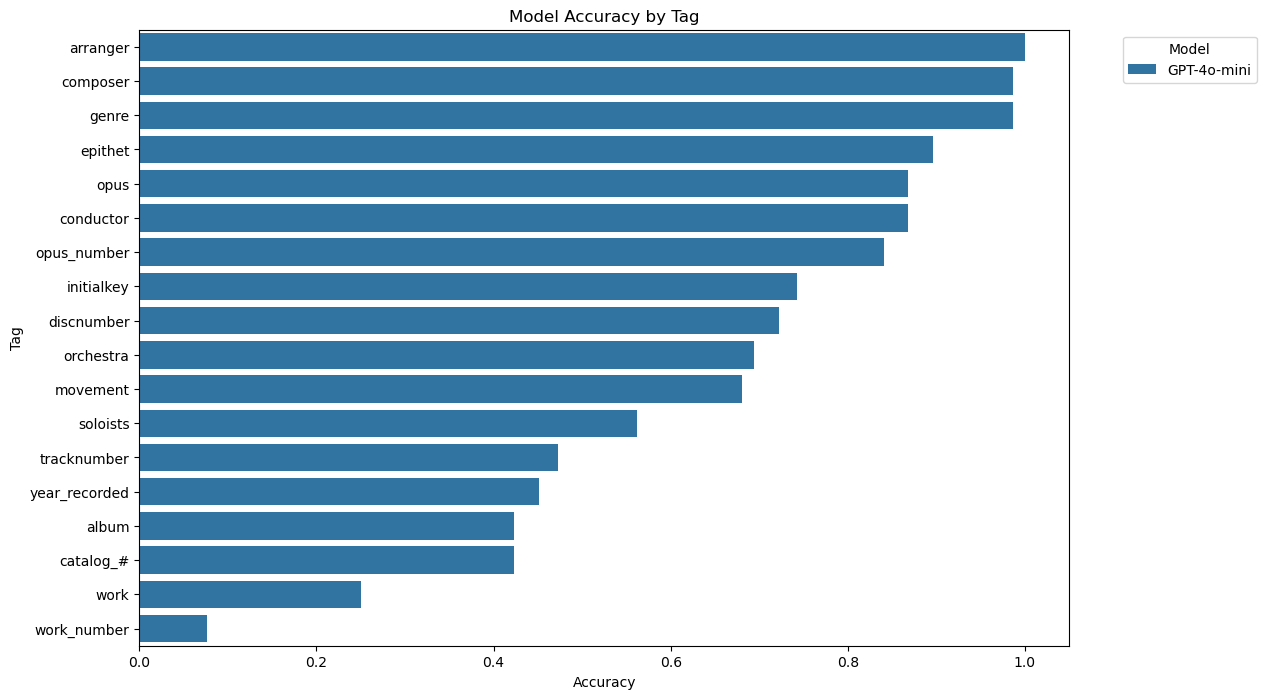

In [11]:
# Calculate overall accuracy for each tag and model
accuracy_df = results_df.groupby(['model', 'tag']).apply(
    lambda x: (x['expected value'] == x['predicted value']).mean()
).reset_index(name='accuracy')
accuracy_df = accuracy_df.sort_values(by='accuracy', ascending=False)

# Horizontal Bar Chart
plt.figure(figsize=(12, 8))
sns.barplot(data=accuracy_df, x='accuracy', y='tag', hue='model', orient='h')
plt.title('Model Accuracy by Tag')
plt.xlabel('Accuracy')
plt.ylabel('Tag')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Oops. For some of these tags, such as arranger, the number of files with an expected value (actual condition positive) is very small. This is not being taken into account. Let's plot the fraction of true positives for each tag instead.

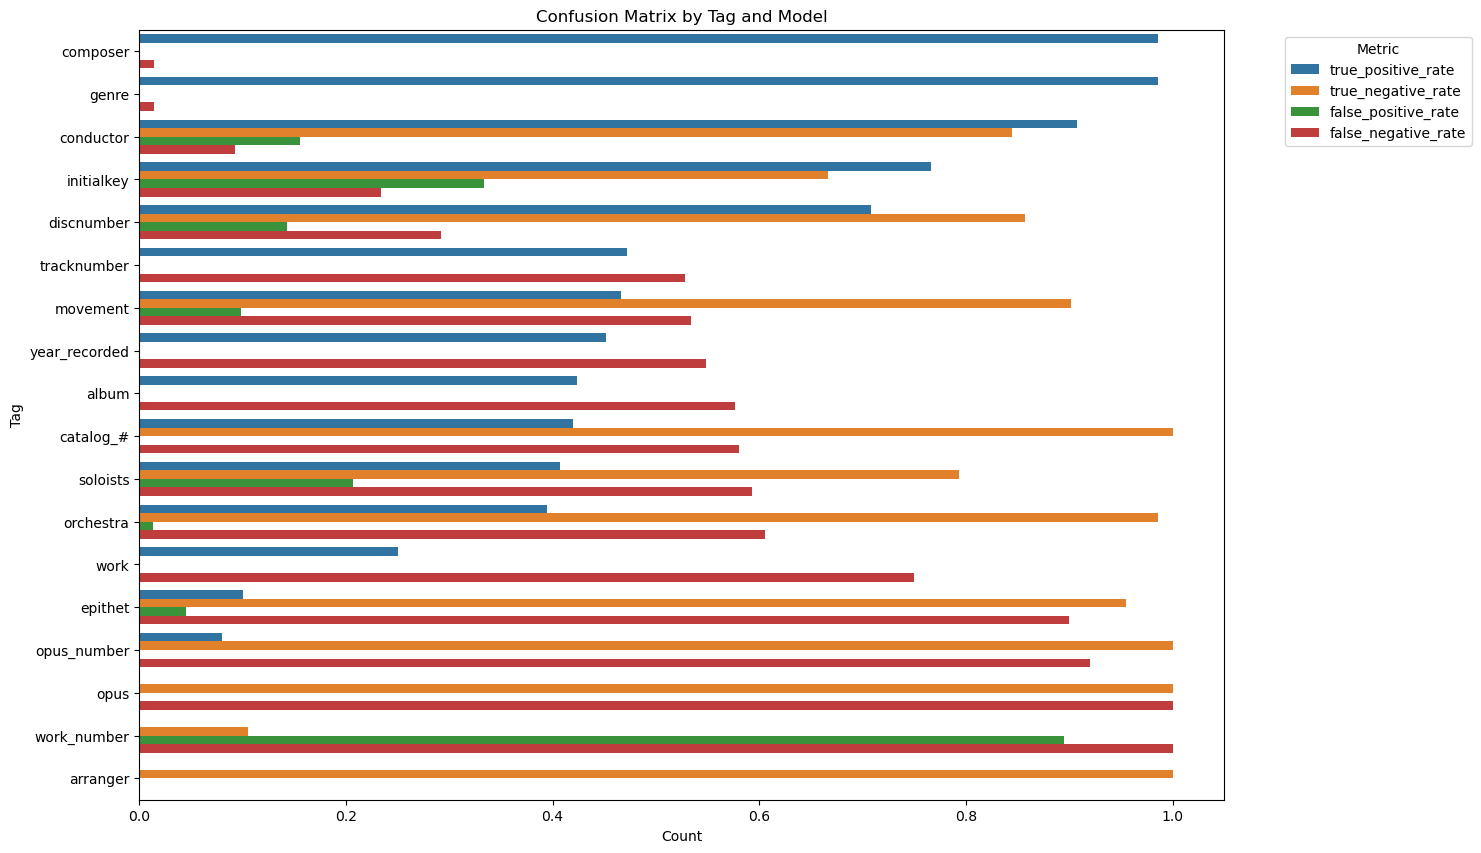

In [22]:
# Confusion matrix
 
# Function to determine if a value is considered "empty". These are the "actual condition negatives"
def is_empty(value):
    return pd.isna(value) or value == ''

# Calculate true positives, true negatives, false positives, and false negatives
def calculate_metrics(row):
    expected = row['expected value']
    predicted = row['predicted value']
    
    if not is_empty(expected) and expected == predicted:
        return 'true_positive'
    elif not is_empty(expected) and expected != predicted:
        return 'false_negative'
    elif is_empty(expected) and is_empty(predicted):
        return 'true_negative'
    elif is_empty(expected) and not is_empty(predicted):
        return 'false_positive'
    
results_df['metric'] = results_df.apply(calculate_metrics, axis=1)

# Aggregate metrics by model and tag
metrics_df = results_df.groupby(['model', 'tag', 'metric']).size().unstack(fill_value=0).reset_index()

# Calculate rates and sort
metrics_df['true_positive_rate'] = metrics_df['true_positive'] / (metrics_df['true_positive'] + metrics_df['false_negative'])
metrics_df['false_positive_rate'] = metrics_df['false_positive'] / (metrics_df['false_positive'] + metrics_df['true_negative'])
metrics_df['true_negative_rate'] = metrics_df['true_negative'] / (metrics_df['true_negative'] + metrics_df['false_positive'])
metrics_df['false_negative_rate'] = metrics_df['false_negative'] / (metrics_df['false_negative'] + metrics_df['true_positive'])
metrics_df = metrics_df.sort_values(by='true_positive_rate', ascending=False)

# Prepare data for plotting
metrics_df = metrics_df.melt(id_vars=['model', 'tag'], value_vars=['true_positive_rate', 'true_negative_rate', 'false_positive_rate', 'false_negative_rate'], var_name='metric', value_name='count')

# Horizontal Bar Plot
plt.figure(figsize=(14, 10))
sns.barplot(data=metrics_df, x='count', y='tag', hue='metric', orient='h')
plt.title('Confusion Matrix by Tag and Model')
plt.xlabel('Rate')
plt.ylabel('Tag')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
M